<a href="https://colab.research.google.com/github/tiffanytang34/Age_Detection_Using_Facial_Image_with_CNN/blob/main/EDA_age_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

from zipfile import ZipFile
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

Exploratory Data Analysis

### *facial-age* dataset (9,778 images)

In [2]:
# Unzipping the dataset file facial-age.zip

#!unzip facial-age.zip
facial_age_zip_path = "/content/drive/My Drive/Age_Detection/facial-age.zip"

with ZipFile(facial_age_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping facial-age.zip')

Done unzipping facial-age.zip


***facial-age* dataset** contains **9,778 RGB images of faces** in **PNG** format of size **200x200 pixels** each. The images are separated into folders where the **folder names correspond to the age labels of images inside those folders**.

In [3]:
# Accessing all folder names to get list of labels.

facial_age_path = "facial-age"
facial_age_folders = os.listdir(facial_age_path)

In [4]:
# Sorting the folder names (age labels) in ascending order.

facial_age_folders = np.sort(facial_age_folders)
facial_age_folders

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '095', '096', '099', '100', '101', '110'],
      dtype='<U3')

 Access the images in the folder and store the info inside a dictionary which has age labels as keys and number of images of certain ages as values. 

In [5]:
facial_age_images = {}

for age in facial_age_folders:
    temp_path = os.path.join(facial_age_path, age)
    n_images = len(os.listdir(temp_path))
    facial_age_images[int(age)] = n_images

### *UTKFace* dataset (23,708 images)

In [6]:
# Unzipping the dataset file UTKFace.zip

utkface_zip_path = "/content/drive/My Drive/Age_Detection/UTKFace.zip"

with ZipFile(utkface_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping UTKFace.zip')

Done unzipping UTKFace.zip


***UTKFace* dataset** contains **23,708 RGB images of faces** in **JPG** format of size **200x200 pixels** each. The **labels of images are embedded in the file names, formatted like *\[age]\_\[gender]\_\[race]\_\[date&time].jpg***.

In [7]:
# Accessing all image file names so as to be able to separate the age labels.

utkface_path = '/content/UTKFace'
utkface_image_names = os.listdir(utkface_path)

In [8]:
# Defining a function to generate the labels from the image file names according to the format given above.

def age_gender_race_split(image_name):
    image_labels = image_name.split('_')
    age = image_labels[0]
    gender = image_labels[1]
    race = image_labels[2]

    return (age, gender, race)

In [9]:
# Applying the above function on each image file name using a for loop and storing the labels in relevant arrays.

utkface_age_labels = np.array([])
utkface_gender_labels = np.array([])
utkface_race_labels = np.array([])

for image in utkface_image_names:
    age, gender, race = age_gender_race_split(image)
    utkface_age_labels = np.append(utkface_age_labels, age)
    utkface_gender_labels = np.append(utkface_gender_labels, gender)
    utkface_race_labels = np.append(utkface_race_labels, race)

In [10]:
# Grouping by the age labels and checking the no. of images per age label.

utkface_ages_counts = pd.Series(utkface_age_labels).value_counts()
utkface_ages_counts

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Length: 104, dtype: int64

In [11]:
# Storing the grouped age labels series generated above in a dictionary with
# the age labels as keys and the no. of images per age label as values.

utkface_images = {}

for age, counts in utkface_ages_counts.items():
    utkface_images[int(age)] = counts

In [12]:
# Grouping by the gender labels and checking the no. of images per gender label.
# 0 = Male, 1 = Female
# This is just for extra info and will not be used in the model.

pd.Series(utkface_gender_labels).value_counts()

0    12391
1    11317
dtype: int64

In [13]:
# Grouping by the race labels and checking the no. of images per race label.
# 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others (like Hispanic, Latino, Middle Eastern)
# This is just for extra info and will not be used in the model.

pd.Series(utkface_race_labels).value_counts()

# 3 images don't have race labels in their file name, as seen below.

0                                 10078
1                                  4526
3                                  3975
2                                  3434
4                                  1692
20170109150557335.jpg.chip.jpg        1
20170116174525125.jpg.chip.jpg        1
20170109142408075.jpg.chip.jpg        1
dtype: int64

### Classes for Age Classification

In this part, I will **combine the different age labels into classes of age-ranges** so as to prepare the datasets for age classification modelling later. 
The classes of ages need to be established according to the number of images available per age label. In this way, the classes of ages will be balanced. This will ensure that the classification model learns to classify each age-range equally.

In [14]:
# Checking no. of unique age values in facial-age dataset.

facial_age_ages = list(facial_age_images.keys())
len(facial_age_ages)

99

In [15]:
# Checking no. of unique age values in UTKFace dataset.

utkface_ages = list(utkface_images.keys())
len(utkface_ages)

104

In [16]:
# Combining the lists of age values from the two datasets and
# converting the combined list to a set to keep only the unique age values.

facial_age_ages.extend(utkface_ages)
unique_ages = set(facial_age_ages)

In [17]:
# Checking no. of unique age values in both datasets combined.

len(unique_ages)

104

In [18]:
# Creating a dictionary of age labels as keys and no. of images per age label in both datasets combined as values,
# using the two dictionaries defined above.

combined_images = {}

for age in unique_ages:
    fc_image = 0
    utk_image = 0

    # Using try-except loop to avoid KeyError in case a particular age value does not exist in the dictionary.
    try:
        fc_image = facial_age_images[age]
    except:
        pass
    
    try:
        utk_image = utkface_images[age]
    except:
        pass
    
    # Summing up the no. of images for the age label.
    combined_images[age] = fc_image + utk_image

In [19]:
# Checking total no. of images in both datasets combined to ensure correctness of above code.

sum(combined_images.values())

33486

In [20]:
# Checking total no. of images by summing up no. of images in facial-age and UTKFace datasets.

sum(facial_age_images.values()) + sum(utkface_images.values())

33486

In [21]:
# Creating a dataframe to store the no. of images per age label in facial-age dataset, UTKFace dataset and the combined dataset.

images_df = pd.DataFrame(combined_images.values(), index=combined_images.keys(), columns=['combined_images'])
images_df['facial_age_images'] = pd.Series(facial_age_images)
images_df['utkface_images'] = pd.Series(utkface_images)

images_df

,combined_images,facial_age_images,utkface_images
1,2235,1112.0,1123
2,957,475.0,482
3,573,284.0,289
4,533,260.0,273
5,376,180.0,196
...,...,...,...
105,5,NaN,5
110,7,2.0,5
111,1,NaN,1
115,3,NaN,3


In [22]:
# Imputing the null values in above dataframe with 0s.

images_df.fillna(0, inplace=True)
images_df = images_df.astype(int)

images_df

,combined_images,facial_age_images,utkface_images
1,2235,1112,1123
2,957,475,482
3,573,284,289
4,533,260,273
5,376,180,196
...,...,...,...
105,5,0,5
110,7,2,5
111,1,0,1
115,3,0,3


In [23]:
# Exporting above created dataframe as a CSV file.

images_df.to_csv("/content/drive/My Drive/Age_Detection/image_summary.csv", index=True, index_label='age')

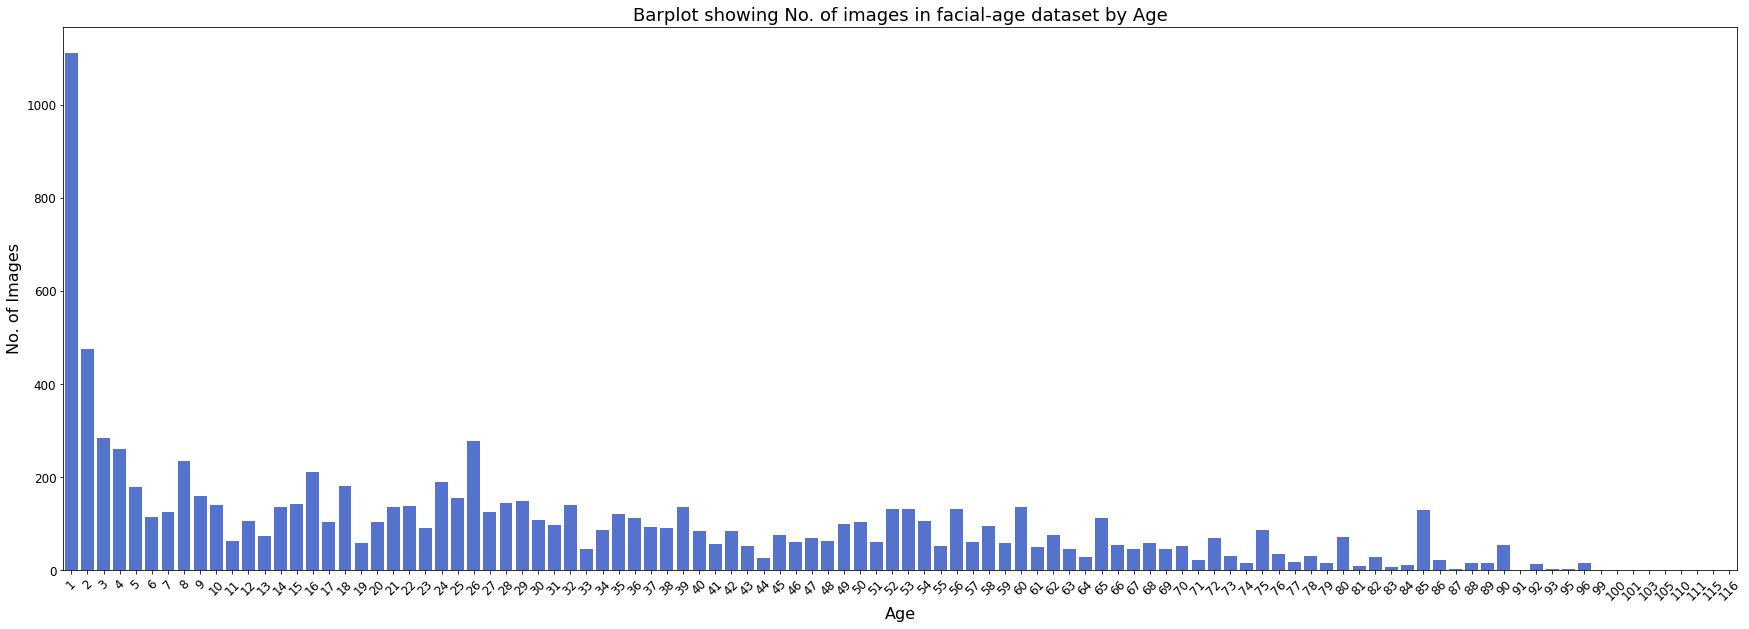

In [25]:
# Plotting the no. of images by ages in a barplot.

plt.figure(figsize=(30, 10))

ax = sns.barplot(x=images_df.index, y=images_df['facial_age_images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelrotation=45)

plt.xlabel("Age", fontsize=16)
plt.ylabel("No. of Images", fontsize=16)

plt.title("Barplot showing No. of images in facial-age dataset by Age", fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Detection/plot_images/barplot_facial_age_images.png', bbox_inches='tight');